In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [46]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [47]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"
audio_file_path = 'audios/tg1.wav'
pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print('Input audio:')
display(ipd.Audio(y, rate=sr))

# Use median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic, percussive = pp.apply_median_filtering(spectrogram)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print('Harmonic component:')
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print('Percussive component:')
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


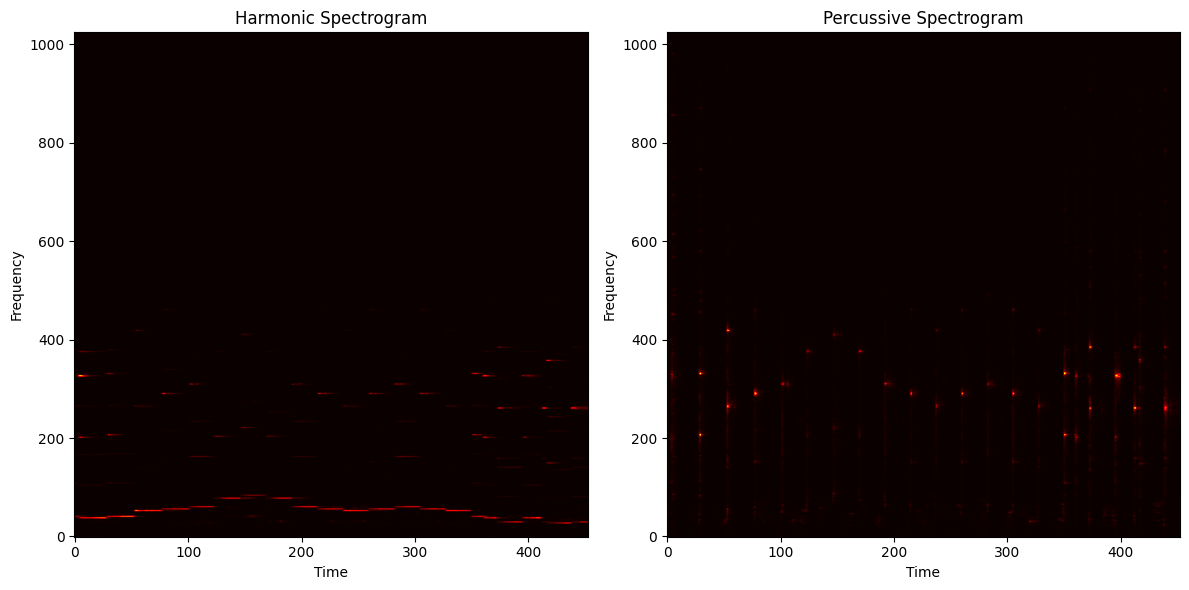

In [48]:
plt.figure(figsize=(12, 6))

# Plot harmonic spectrogram
plt.subplot(1, 2, 1)
plt.imshow(harmonic, aspect='auto', origin='lower', cmap='hot')
plt.title('Harmonic Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

# Plot percussive spectrogram
plt.subplot(1, 2, 2)
plt.imshow(percussive, aspect='auto', origin='lower', cmap='hot')
plt.title('Percussive Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

plt.tight_layout()
plt.show()

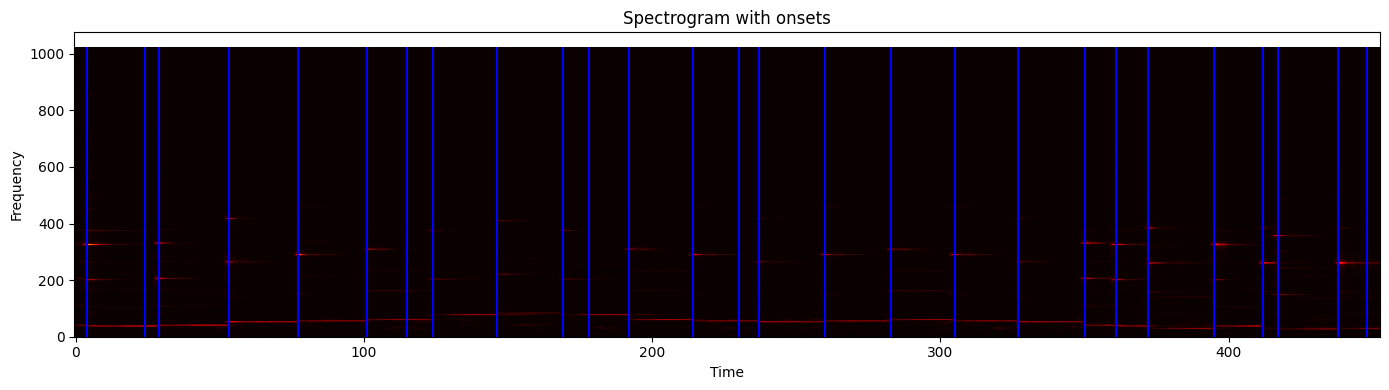

In [49]:
# Assuming you have already computed 'percussive_audio', 'sr', and 'spectrogram'

onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='hot')

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color='blue', linestyle='-')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Spectrogram with onsets')

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [50]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")


In [51]:
time, frequency, confidence, activation = pitch_est.estimate_crepe(harmonic_audio, sr)

33/33 [==============================] - 26s 790ms/step


In [52]:
import utils as u

seg = u.segment_stable_frequency_regions(frequency, stdThsld=5, minNoteDur=0.5, winStable=5, fs=sr, H=512)

Text(0.5, 1.0, 'Crepe Frequencies')

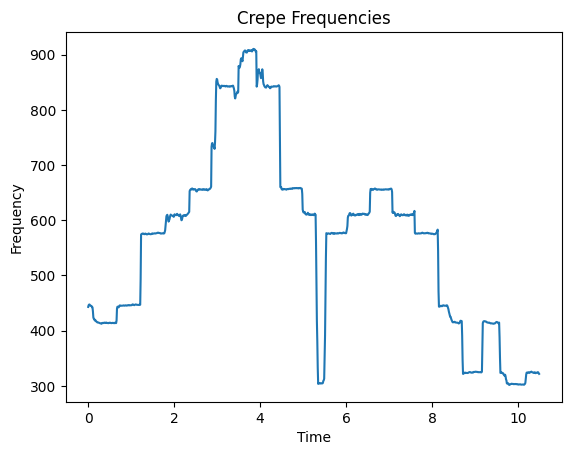

In [53]:
# Plot the interpolated frequencies
plt.plot(time, frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Crepe Frequencies')


In [54]:
tones = []
stable_segments_idxs = []
# function used in exercise

import numpy as np

def select_stable_part(segment, threshold=0.1):
    """
    Selects the most stable part of a segment based on standard deviation.
    
    Parameters:
        segment (ndarray): Array containing the fundamental frequency estimates for the segment.
        threshold (float): Threshold to consider a part as stable. Default is 0.1.
        
    Returns:
        stable_part (ndarray): The most stable part of the segment.
    """
    std_dev = np.std(segment)
    if std_dev < threshold:
        return segment
    else:
        # Split segment into halves and recursively select the stable part
        mid = len(segment) // 2
        left_part = select_stable_part(segment[:mid], threshold)
        right_part = select_stable_part(segment[mid:], threshold)
        return np.concatenate((left_part, right_part))
   


for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1: index_b = len(time) - 1
    else: index_b = np.argmax(time > onsets[i+1])

    # this was the attempt to try to get the frequency with the highest confidence value. not working :(
    
    # most_confident_idx = np.argmax(confidence[index_a:index_b])
    # fq = frequency[most_confident_idx]
    # # print(fq)
    # tones.append(fq)

    frequency_segment = frequency[index_a:index_b]
    stable_freq_seg = select_stable_part(frequency_segment, threshold=0.5)
    
    # Calculate time indices for stable segment
    stable_index_a = time[index_a + np.argmax(frequency_segment == stable_freq_seg[0])]
    stable_index_b = time[index_a + np.argmax(frequency_segment == stable_freq_seg[-1]) + 1]
    
    # Store the time indices of the stable segment
    stable_segments_idxs.append((stable_index_a, stable_index_b))

    # print("original segment:", frequency_segment, "\n")
    print("stable segment:", stable_freq_seg, "\n")

    tone = np.median(stable_freq_seg)
    # print(f'Onset {i}-{i+1}: {tone}')
    tones.append(tone)

    # if i == 57:
    # #     audio = harmonic_audio[int(onset*sr):int(onsets[i+1]*sr)]
    # #     display(ipd.Audio(audio, rate=sr))
    # #     plt.plot(audio)


# # Plot the interpolated frequencies
# plt.plot(time, frequency)
# plt.xlabel('Time') 
# plt.ylabel('Frequency')
# plt.title('Crepe Frequencies')

# for t in onsets:
#     plt.axvline(x=round(t, 2), color='r', linestyle='-', label=f'Time {t}')

# plt.show()

stable segment: [442.31533005 434.84344193 423.96656148 421.59354858 421.36575607
 418.88004261 418.3259738  418.85971011 417.45759787 416.3979031
 416.10625026 415.1144286  414.80815751 415.06825419 414.71331964
 414.36561108 414.00068661 413.80881529 413.36450797 413.29015399
 412.92582724 412.57053609 413.3657093  413.97660753 414.06558813
 414.18218108 413.79507136 414.13326971 414.65973927 414.46932283
 414.03419179 414.14228021 414.65258231 413.97143817 414.15033555
 413.85251225 413.70098294 413.6082182  414.07198863 414.44610749
 414.18029516 414.3767965  414.25795711 413.73415646 413.65896704
 413.74208911] 

stable segment: [414.17260815 413.92830673 414.22121588 413.9239393  413.61056826
 413.61678014 414.39082153 414.22581024 413.72587098 413.81720667
 418.72398931 440.27305812] 

stable segment: [443.31543891 443.52393969 442.3472126  442.37498943 444.07860895
 445.60206218 445.81474249 445.42575654 445.15328493 445.19730444
 445.33282749 445.27530969 445.254271   445.4198

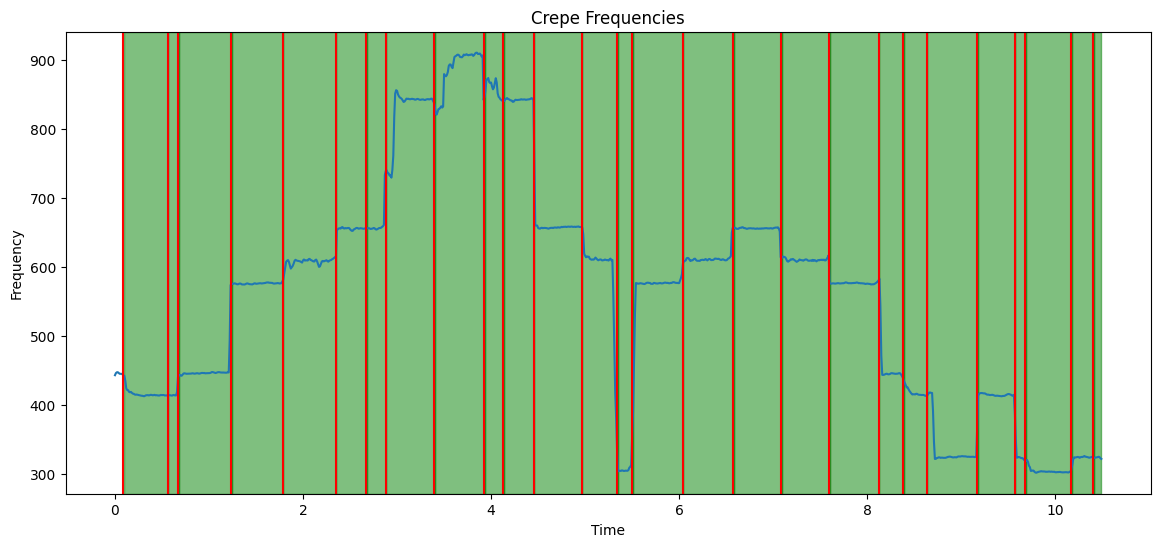

In [55]:
# for t in tones:
#     audio = librosa.tone(t, duration=1)
#     print(f'Playing t {t}')
#     display(ipd.Audio(audio, rate=sr))
plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Plot the interpolated frequencies
plt.plot(time, frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Crepe Frequencies')

for t in onsets:
    plt.axvline(x=round(t, 2), color='r', linestyle='-', label=f'Time {t}')


# # Plot stable segments
# for idxs in stable_segments_idxs:
#     plt.axvspan(idxs[0], idxs[1], color='green', alpha=0.5)
# plt.show()
    

In [56]:
# function used in exercise

import numpy as np
def group_and_average_frequencies(frequencies, threshold=5):
    frequencies = sorted(frequencies)
    grouped_frequencies = []
    current_group = [frequencies[0]]
    
    for i in range(1, len(frequencies)):
        if frequencies[i] - frequencies[i-1] <= threshold:
            current_group.append(frequencies[i])
        else:
            grouped_frequencies.append(sum(current_group) / len(current_group))
            current_group = [frequencies[i]]
    
    grouped_frequencies.append(sum(current_group) / len(current_group))
    
    return grouped_frequencies

In [57]:
grouped_averaged_frequencies = group_and_average_frequencies(tones)
print(grouped_averaged_frequencies)

[303.9454046422517, 324.12695849644547, 414.54278332379704, 445.6127408141946, 576.2408809119124, 609.8608748708061, 656.3014671575204, 842.5190825896454, 859.7537399485806, 904.8358960755265]


In [58]:
for tone in grouped_averaged_frequencies:
    audio = librosa.tone(tone, duration=1)
    print(f'Playing tone {tone}')
    display(ipd.Audio(audio, rate=sr))

Playing tone 303.9454046422517


Playing tone 324.12695849644547


Playing tone 414.54278332379704


Playing tone 445.6127408141946


Playing tone 576.2408809119124


Playing tone 609.8608748708061


Playing tone 656.3014671575204


Playing tone 842.5190825896454


Playing tone 859.7537399485806


Playing tone 904.8358960755265
